In [9]:
import pynq
from pynq.overlays.base import BaseOverlay
from pynq import Overlay
import pynq.lib.dma
from pynq import Xlnk
import time
import numpy as np
import scipy.signal as signal
from pynq import MMIO


ol = BaseOverlay("base.bit")

#ol.ip_dict

# MicroBlaze Interface with PMODA

In [10]:
%%microblaze ol.PMODA

#include <spi.h>
#include <stdint.h>
#include <pyprintf.h>

#define CS_A_PIN		0
#define CS_M_PIN		6
#define MOSI_PIN		1
#define MISO_PIN		2
#define CLK_PIN			3

#define BUFF_SIZE		7


#define ACC_X_L_ADDR     0x28
#define MAG_X_L_ADDR     0x28
/*
#define X_H_ADDR     0x29
#define Y_L_ADDR     0x2A
#define Y_H_ADDR     0x2B
#define Z_L_ADDR     0x2C
#define Z_H_ADDR     0x2D
*/

#define CTRL_REG6_XL_ADDR    0x20

#define X_DIR_SEL       0x01
#define Y_DIR_SEL       0x02
#define Z_DIR_SEL       0x03

#define READ_CFG       1<<7
#define WRITE_CFG      0x7F
#define MS_CFG         0xC0

#define STATE_ON       0x01
#define STATE_OFF      0x00

#define CTRL_REG5_XL   0x1F
#define CTRL_REG6_XL   0x20

#define CTRL_REG1_M    0x20
#define CTRL_REG2_M    0x21
#define CTRL_REG3_M    0x22
#define CTRL_REG4_M    0x23
#define CTRL_REG5_M    0x24


int SPI_Write(uint8_t addr, uint8_t val, uint8_t CS)
{
    uint8_t tx_buff[BUFF_SIZE] = {0};
    uint8_t rx_buff[BUFF_SIZE] = {0};
    
    tx_buff[0] = addr & WRITE_CFG;
    tx_buff[1] = val;
    
    spi nav = spi_open(CLK_PIN, MISO_PIN, MOSI_PIN, CS);
    
    spi_transfer(nav, (char*)tx_buff, (char*)rx_buff, 2);
    
    //pyprintf("Write - TX_BUFF: [%x, %x]\r\n", tx_buff[0], tx_buff[1]);
    //pyprintf("Write - RX_BUFF: [%x, %x]\r\n", rx_buff[0], rx_buff[1]);
    
    spi_close(nav);
    
    return 0;
}

uint8_t SPI_Read(uint8_t addr, uint8_t CS)
{
    uint8_t tx_buff[BUFF_SIZE] = {0};
    uint8_t rx_buff[BUFF_SIZE] = {0};
    
    tx_buff[0] = addr | READ_CFG;
    
    
    spi nav = spi_open(CLK_PIN, MISO_PIN, MOSI_PIN, CS);
    
    spi_transfer(nav, (char*)tx_buff, (char*)rx_buff, 2);
    
    spi_close(nav);
    
    //pyprintf("Read - TX_BUFF: [%x, %x]\r\n", tx_buff[0], tx_buff[1]);
    //pyprintf("Read - RX_BUFF: [%x, %x]\r\n", rx_buff[0], rx_buff[1]);
    
    return rx_buff[1];
}

int Nav_Acc_Pwr(uint8_t state)
{
    uint8_t temp_val = 0x00;
    
    if(state == STATE_ON)
    {
        //enable all three axes
        //pyprintf("--ACC Power ON--\r\n");
        
        SPI_Write(CTRL_REG5_XL, 0x38, CS_A_PIN);
        //pyprintf("CTRL_REG5_XL: %x\r\n", SPI_Read(CTRL_REG5_XL, CS_A_PIN));
        //set 10Hz odr for accelerometer
        SPI_Write(CTRL_REG6_XL, 0x20, CS_A_PIN);
        //pyprintf("CTRL_REG6_XL: %x\r\n", SPI_Read(CTRL_REG6_XL, CS_A_PIN));
    }
    else
    {
        pyprintf("--ACC Power OFF--\r\n");
        
        SPI_Write(CTRL_REG5_XL, 0x00, CS_A_PIN);
        //pyprintf("CTRL_REG5_XL: %x\r\n", SPI_Read(CTRL_REG5_XL, CS_A_PIN));
        SPI_Write(CTRL_REG6_XL, 0x00, CS_A_PIN);
        //pyprintf("CTRL_REG6_XL: %x\r\n", SPI_Read(CTRL_REG6_XL, CS_A_PIN));
        
    }
    return 0;
}

int Nav_Mag_Pwr(uint8_t state)
{
    if(state == STATE_ON)
    {
        //pyprintf("--MAG Power ON--\r\n");
        //set medium performance mode for x and y and 10Hz ODR for MAG, 
        SPI_Write(CTRL_REG1_M, 0x30, CS_M_PIN);
        //pyprintf("CTRL_REG1_M, %x\r\n", SPI_Read(CTRL_REG1_M, CS_M_PIN));
        
        //set scale to +-4Gauss
        SPI_Write(CTRL_REG2_M, 0x00, CS_M_PIN);
        //pyprintf("CTRL_REG2_M, %x\r\n", SPI_Read(CTRL_REG2_M, CS_M_PIN));
        
        //disable I2C and enable SPI read and write operations, 
        //set the operating mode to continuous conversion
        SPI_Write(CTRL_REG3_M, 0x00, CS_M_PIN);
        //pyprintf("CTRL_REG3_M, %x\r\n", SPI_Read(CTRL_REG3_M, CS_M_PIN));
        
        //set medium performance mode for z axis
        SPI_Write(CTRL_REG4_M, 0x04, CS_M_PIN);
        //pyprintf("CTRL_REG4_M, %x\r\n", SPI_Read(CTRL_REG4_M, CS_M_PIN));
        
        //continuous update of output registers
        SPI_Write(CTRL_REG5_M, 0x00, CS_M_PIN);
        //pyprintf("CTRL_REG5_M, %x\r\n", SPI_Read(CTRL_REG5_M, CS_M_PIN));
    }
    else
    {
        //pyprintf("--MAG Power OFF--\r\n");
        //power down the instrument
        SPI_Write(CTRL_REG3_M, 0x03, CS_M_PIN);
    }
}

int Nav_Acc_GetData(uint8_t axis)
{
    uint8_t tx_buff[7] = {0};
    uint8_t rx_buff[7] = {0};
    
    int16_t acc_x = 0;
    int16_t acc_y = 0;
    int16_t acc_z = 0;
    
    tx_buff[0] = ACC_X_L_ADDR | READ_CFG;
    
    spi nav = spi_open(CLK_PIN, MISO_PIN, MOSI_PIN, CS_A_PIN);
    
    spi_transfer(nav, (char*)tx_buff, (char*)rx_buff, 7);
    
    spi_close(nav);
    
    //pyprintf("Test - TX_BUFF: [%x, %x, %x, %x, %x, %x, %x]\r\n", tx_buff[0], tx_buff[1], tx_buff[2], tx_buff[3], tx_buff[4], tx_buff[5], tx_buff[6]);
    //pyprintf("Test - RX_BUFF: [%x, %x, %x, %x, %x, %x, %x]\r\n", rx_buff[0], rx_buff[1], rx_buff[2], rx_buff[3], rx_buff[4], rx_buff[5], rx_buff[6]);
    
    acc_x = rx_buff[2]<<8 | rx_buff[1];
    acc_y = rx_buff[4]<<8 | rx_buff[3];
    acc_z = rx_buff[6]<<8 | rx_buff[5];
    
    //pyprintf("Nav_Acc_GetData: x: %d\r\n", acc_x);
    //pyprintf("Nav_Acc_GetData: y: %d\r\n", acc_y);
    //pyprintf("Nav_Acc_GetData: z: %d\r\n", acc_z);
    
    if(axis == X_DIR_SEL)
    {
        return acc_x;
    }
    else if(axis == Y_DIR_SEL)
    {
        return acc_y;
    }
    else
    {
        return acc_z;
    }
    
    return 0;
}

int Nav_Mag_GetData(uint8_t axis)
{
    uint8_t tx_buff[7] = {0};
    uint8_t rx_buff[7] = {0};
    
    int16_t mag_x = 0;
    int16_t mag_y = 0;
    int16_t mag_z = 0;
    
    tx_buff[0] = MAG_X_L_ADDR | READ_CFG;
    tx_buff[0] = tx_buff[0] | MS_CFG;
    
    spi nav = spi_open(CLK_PIN, MISO_PIN, MOSI_PIN, CS_M_PIN);
    
    spi_transfer(nav, (char*)tx_buff, (char*)rx_buff, 7);
    
    spi_close(nav);
    
    //pyprintf("Nav_Mag_GetData: TX_BUFF: [%x, %x, %x, %x, %x, %x, %x]\r\n", tx_buff[0], tx_buff[1], tx_buff[2], tx_buff[3], tx_buff[4], tx_buff[5], tx_buff[6]);
    //pyprintf("Nav_Mag_GetData: RX_BUFF: [%x, %x, %x, %x, %x, %x, %x]\r\n", rx_buff[0], rx_buff[1], rx_buff[2], rx_buff[3], rx_buff[4], rx_buff[5], rx_buff[6]);
    
    mag_x = rx_buff[2]<<8 | rx_buff[1];
    mag_y = rx_buff[4]<<8 | rx_buff[3];
    mag_z = rx_buff[6]<<8 | rx_buff[5];
    
    //pyprintf("Nav_Mag_GetData: x: %d\r\n", mag_x);
    //pyprintf("Nav_Mag_GetData: y: %d\r\n", mag_y);
    //pyprintf("Nav_Mag_GetData: z: %d\r\n", mag_z);
    
    if(axis == X_DIR_SEL)
    {
        return mag_x;
    }
    else if(axis == Y_DIR_SEL)
    {
        return mag_y;
    }
    else
    {
        return mag_z;
    }
    
    return 0;
}



# Single Sample to Collect Data for MAG Offset Calibration

In [62]:
Nav_Acc_Pwr(1)
Nav_Mag_Pwr(1)

print(Nav_Acc_GetData(0x01), ' ', Nav_Acc_GetData(0x02), ' ', Nav_Acc_GetData(0x03))
print(Nav_Mag_GetData(0x01), ' ', Nav_Mag_GetData(0x02), ' ', Nav_Mag_GetData(0x03))

-272   -55   15899
-10335   9121   28812


# Pull Data From NAV Into Buffer

In [11]:

Nav_Acc_Pwr(1)
Nav_Mag_Pwr(1)

mag_x_offset = -360
mag_y_offset = -1723
mag_z_offset = -4583

mag_x_flip = 1
mag_y_flip = -1
mag_z_flip = 1

acc_x_flip = -1
acc_y_flip = -1
acc_z_flip = 1

ACC = list()
MAG = list()
HPR = list()
heading = list()
pitch = list()
roll = list()

T_SAMPLE = 30
FS = 2
N_SAMPLE = T_SAMPLE*FS

for x in range(0, N_SAMPLE):
    acc_x = acc_x_flip*Nav_Acc_GetData(0x01)
    acc_y = acc_y_flip*Nav_Acc_GetData(0x02)
    acc_z = acc_z_flip*Nav_Acc_GetData(0x03)

    ACC.append(acc_x);
    ACC.append(acc_y);
    ACC.append(acc_z);

    mag_x = mag_x_flip*(Nav_Mag_GetData(0x01) - mag_x_offset)
    mag_y = mag_y_flip*(Nav_Mag_GetData(0x02) - mag_y_offset)
    mag_z = mag_z_flip*(Nav_Mag_GetData(0x03) - mag_z_offset)

    MAG.append(mag_x)
    MAG.append(mag_y)
    MAG.append(mag_z)
    
    HPR.append(0)
    HPR.append(0)
    HPR.append(0)
    
    heading.append(0)
    pitch.append(0)
    roll.append(0)
    
    print("ACC:", ACC[(x*3) + 0], "\t", ACC[(x*3) + 1], "\t", ACC[(x*3) + 2], "\r\n")
    print("MAG:", MAG[x], "\t", MAG[x + 1], "\t", MAG[x + 2], "\r\n")
    
    time.sleep(1/FS)
    

'''
ACC[0] = 50
ACC[1] = 0
ACC[2] = 50

MAG[0] = 100
MAG[1] = 100
MAG[2] = 0
 '''
    

ACC: -13 	 -332 	 15939 

MAG: 3698 	 -2225 	 -1556 

ACC: 188 	 -387 	 15962 

MAG: -2225 	 -1556 	 3723 

ACC: 140 	 -370 	 15909 

MAG: -1556 	 3723 	 -2185 

ACC: 249 	 -433 	 15931 

MAG: 3723 	 -2185 	 -1582 

ACC: 194 	 -325 	 15959 

MAG: -2185 	 -1582 	 3696 

ACC: 172 	 -363 	 15915 

MAG: -1582 	 3696 	 -2243 

ACC: -209 	 -1248 	 18142 

MAG: 3696 	 -2243 	 -1609 

ACC: -2676 	 -1266 	 15183 

MAG: -2243 	 -1609 	 3719 

ACC: -1791 	 -967 	 15317 

MAG: -1609 	 3719 	 -2226 

ACC: -1329 	 -805 	 15570 

MAG: 3719 	 -2226 	 -1610 

ACC: -2142 	 2017 	 16176 

MAG: -2226 	 -1610 	 3707 

ACC: -2262 	 1458 	 15686 

MAG: -1610 	 3707 	 -2190 

ACC: -902 	 -657 	 15235 

MAG: 3707 	 -2190 	 -1578 

ACC: -21 	 1264 	 15392 

MAG: -2190 	 -1578 	 3740 

ACC: 333 	 1381 	 15676 

MAG: -1578 	 3740 	 -2203 

ACC: 443 	 1185 	 16539 

MAG: 3740 	 -2203 	 -1543 

ACC: -301 	 -6145 	 14329 

MAG: -2203 	 -1543 	 3680 

ACC: 356 	 -14512 	 13601 

MAG: -1543 	 3680 	 -2161 

ACC: 177 	

'\nACC[0] = 50\nACC[1] = 0\nACC[2] = 50\n\nMAG[0] = 100\nMAG[1] = 100\nMAG[2] = 0\n '

# Load Custom HLS to Process ACC/MAG Data

In [12]:
# HLS register addresses
IP_CTRL = 0x00
AP_START = 0x1
GIER = 0x04
IP_IER = 0x08
IP_ISR = 0x0C
INTRPT_AP_DONE = 0x1
INTRPT_AP_READY = 0x2

ol_hls = Overlay('HPR.bit') # load bitstream - check against your bitstream name and location
#t_before_bitstream = time.time()
ol_hls.download() # download bitstream to FPGA
#print(ol_hls.ip_dict)  # print overlay contents
#t_after_bitstream = time.time()
#print(t_after_bitstream - t_before_bitstream, 'seconds to program bitstream')



dma_0 = ol_hls.axi_dma_0 # TX: ACC RX: HPR
dma_1 = ol_hls.axi_dma_1 # TX: MAG 
HPR_ip = ol_hls.HPR_0 # HLS core
HPR_ip.write(GIER, 0x1) # disable interrupts

in_buffer_length = 3



# get input data for the HLS core from the sensors 
#print('processing buffer_{} ...'.format(i))

ACC_tmp = list()
ACC_tmp.append(0)
ACC_tmp.append(0)
ACC_tmp.append(0)

MAG_tmp = list()
MAG_tmp.append(0)
MAG_tmp.append(0)
MAG_tmp.append(0)

HPR_tmp = list()
HPR_tmp.append(0)
HPR_tmp.append(0)
HPR_tmp.append(0)

for x in range(0, N_SAMPLE):
    ACC_tmp[0] = ACC[(x*3) + 0]
    ACC_tmp[1] = ACC[(x*3) + 1]
    ACC_tmp[2] = ACC[(x*3) + 2]
    
    MAG_tmp[0] = MAG[(x*3) + 0]
    MAG_tmp[1] = MAG[(x*3) + 1]
    MAG_tmp[2] = MAG[(x*3) + 2]
    
    
    xlnk = Xlnk()
    in_buffer_MAG = xlnk.cma_array(shape=(in_buffer_length,), dtype=np.float32)
    in_buffer_ACC = xlnk.cma_array(shape=(in_buffer_length,), dtype=np.float32)
    out_buffer_HPR = xlnk.cma_array(shape=(in_buffer_length,), dtype=np.float32)
    
    np.copyto(in_buffer_MAG[0:in_buffer_length], MAG_tmp[0:in_buffer_length]) # copy mag input data to input buffer
    np.copyto(in_buffer_ACC[0:in_buffer_length], ACC_tmp[0:in_buffer_length]) # copy mag input data to input buffer
    
    dma_0.sendchannel.transfer(in_buffer_ACC)    # write input buffer mag to dma_0.inp
    dma_1.sendchannel.transfer(in_buffer_MAG)    # write input buffer acc to dma_1.inp
    dma_0.recvchannel.transfer(out_buffer_HPR) # write dma_0.out to output buffer heading
    
    
    HPR_ip.write(IP_CTRL, AP_START) # start the core
    dma_0.sendchannel.wait()
    dma_1.sendchannel.wait()
    dma_0.recvchannel.wait()
    
    #print(i, "output buffer (I)", out_bufferI)
    #print(i, "output buffer (R)", out_bufferR)
 
    HPR_tmp = out_buffer_HPR.tolist()
    
    
    HPR[(x*3) + 0] = HPR_tmp[0]
    HPR[(x*3) + 1] = HPR_tmp[1]
    HPR[(x*3) + 2] = HPR_tmp[2]
    heading[x] = HPR_tmp[0]
    pitch[x] = HPR_tmp[1]
    roll[x] = HPR_tmp[2]
    


# Display Data from Custom HLS

In [5]:
import numpy as np

def cart2pol(x, y):
   radius = np.hypot(x, y)
   theta = np.arctan2(y, x)
   return theta, radius


In [13]:


import matplotlib.pyplot as plt
import time
def compass(u, v, arrowprops=None):

   angles, radii = cart2pol(u, v)

   fig, (ax)= plt.subplots(subplot_kw=dict(polar=True))
   
   #ax=plt.subplot(122)
   ax.set_theta_zero_location('N')
   ax.set_theta_direction(-1)
 
   kw = dict("", color='DarkOrange')
   if arrowprops:
       kw.update(arrowprops)
   [ax.annotate("", xy=(angle, radius), xytext=(0, 0),
                arrowprops=kw) for
    angle, radius in zip(angles, radii)]

   ax.set_ylim(0, np.max(radii))

   return fig,(ax)

In [154]:
print("ACC: ", ACC, "\r\n")
print("MAG: ", MAG, "\r\n")
print("HPR: ", HPR, "\r\n")
print("heading", heading, "\r\n")

ACC:  [242, 62, 15948, 264, 85, 15920, 256, 56, 15921, 253, 72, 15919, 256, 62, 15916, 247, 70, 15916, 259, 74, 15922, 265, 59, 15905, 256, 61, 15922, 238, 73, 15899] 

MAG:  [381, 1170, 1615, 437, 1216, 1622, 400, 1125, 1635, 451, 1174, 1661, 398, 1169, 1664, 416, 1179, 1678, 403, 1157, 1708, 398, 1174, 1651, 408, 1156, 1647, 419, 1175, 1657] 

HPR:  [1.8663820028305054, -0.015173036605119705, 0.003887615166604519, 1.896533489227295, -0.016581157222390175, 0.005339145194739103, 1.8913706541061401, -0.016077907755970955, 0.0035173525102436543, 1.918195366859436, -0.015891458839178085, 0.004522866103798151, 1.8782132863998413, -0.01608293503522873, 0.003895431524142623, 1.8904132843017578, -0.015517579391598701, 0.00439806142821908, 1.8847249746322632, -0.01626519113779068, 0.004647623747587204, 1.8763030767440796, -0.016659772023558617, 0.003709508338943124, 1.8895221948623657, -0.01607687957584858, 0.003831158159300685, 1.8947614431381226, -0.01496822014451027, 0.004591451492160559] 


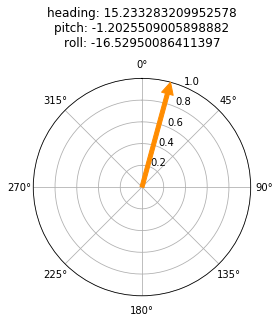

In [14]:

%matplotlib inline
import math
import time
import pylab as pl
from IPython import display



for x in range(0, N_SAMPLE):
   u = [math.cos(heading[x])]
   v = [math.sin(heading[x])]
    
   fig, ax = compass(u, v)
    
   ax.set_title('heading: ' + str(heading[x]*180/3.14) + '\npitch: ' + str(pitch[x]*180/3.14) + '\nroll: ' + str(roll[x]*180/3.14) + '\n')

   display.display(pl.gcf())
   #time.sleep(1/(FS*5));

   display.clear_output(wait=True)
   
   pl.close("all");